## 📥 Importación de librerías y carga de datos desde la base SQLite

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

conn = sqlite3.connect('BDD.db')
productos = pd.read_sql_query("SELECT * FROM tb_productos", conn)
stocks = pd.read_sql_query("SELECT * FROM tb_stocks", conn)
sellin = pd.read_sql_query("SELECT * FROM tb_sellin", conn)


## 👀 Vista previa de los primeros registros de cada tabla

In [4]:
print("Productos")
display(productos.head())
print("Stocks")
display(stocks.head())
print("Sell-in")
display(sellin.head())


Productos


,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


Stocks


,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


Sell-in


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


## ℹ️ Información general de cada tabla

In [5]:
print("Info productos")
productos.info()
print("Info stocks")
stocks.info()
print("Info sell-in")
sellin.info()


Info productos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cat1        1262 non-null   object
 1   cat2        1262 non-null   object
 2   cat3        1262 non-null   object
 3   brand       1262 non-null   object
 4   sku_size    1262 non-null   int64 
 5   product_id  1262 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 59.3+ KB
Info stocks
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13691 entries, 0 to 13690
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   periodo      13691 non-null  int64  
 1   product_id   13691 non-null  int64  
 2   stock_final  13691 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 321.0 KB
Info sell-in
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 

## 📊 Análisis descriptivo: distribución de marcas y registros por período

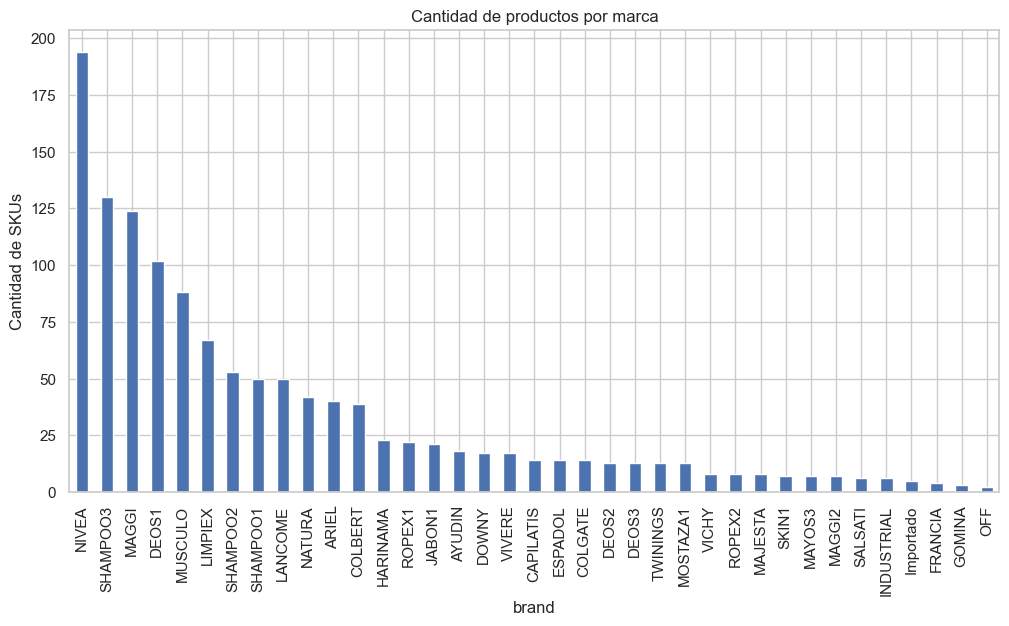

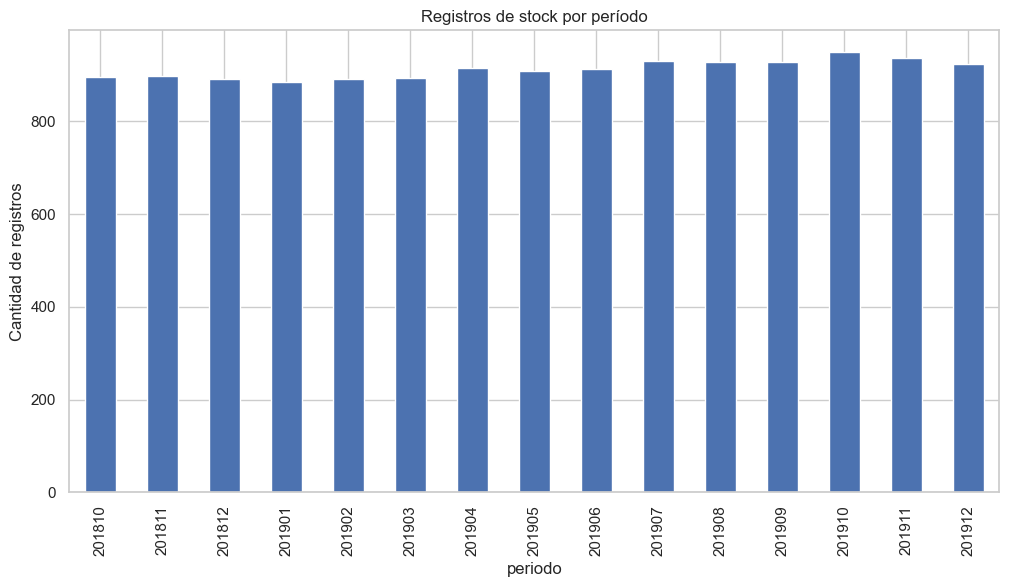

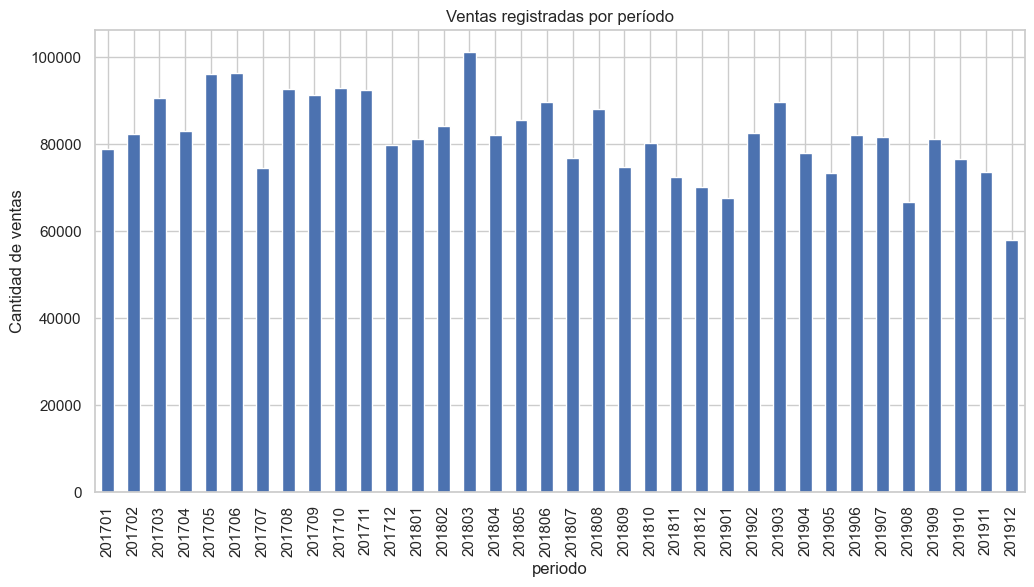

In [6]:
productos['brand'].value_counts().plot(kind='bar', title='Cantidad de productos por marca')
plt.ylabel("Cantidad de SKUs")
plt.show()

stocks['periodo'].value_counts().sort_index().plot(kind='bar', title='Registros de stock por período')
plt.ylabel("Cantidad de registros")
plt.show()

sellin['periodo'].value_counts().sort_index().plot(kind='bar', title='Ventas registradas por período')
plt.ylabel("Cantidad de ventas")
plt.show()


## 🔗 Unión de tablas para análisis enriquecido

In [7]:
sellin_full = pd.read_sql_query('''
SELECT v.*, p.brand, p.sku_size
FROM tb_sellin v
JOIN tb_productos p ON v.product_id = p.product_id
''', conn)

stocks_full = pd.read_sql_query('''
SELECT s.*, p.brand, p.sku_size
FROM tb_stocks s
JOIN tb_productos p ON s.product_id = p.product_id
''', conn)


## 🥇 Top 10 productos más vendidos

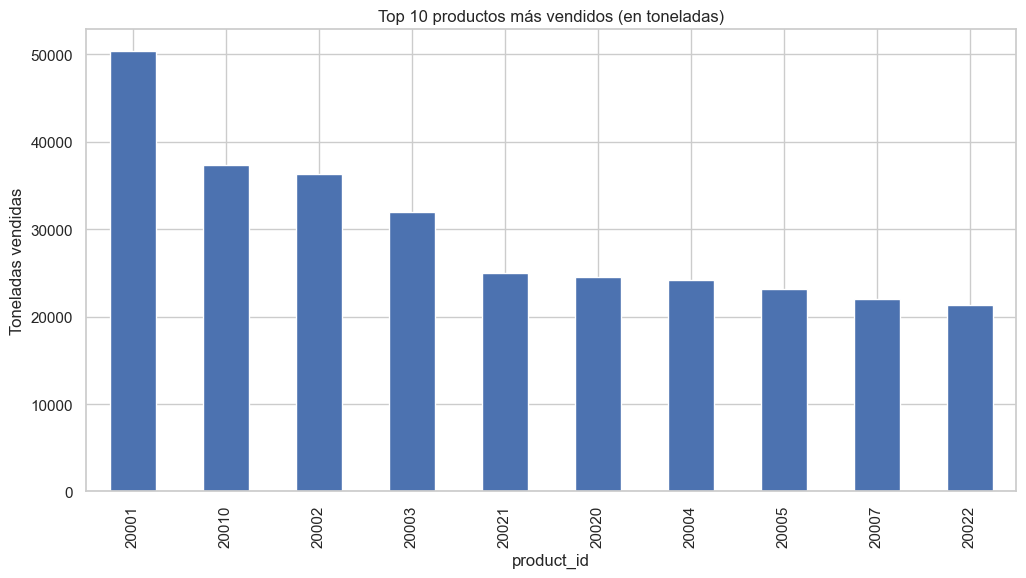

In [8]:
top = sellin_full.groupby('product_id')['tn'].sum().sort_values(ascending=False).head(10)
top.plot(kind='bar', title='Top 10 productos más vendidos (en toneladas)')
plt.ylabel("Toneladas vendidas")
plt.show()


## ⏳ Evolución de ventas en el tiempo

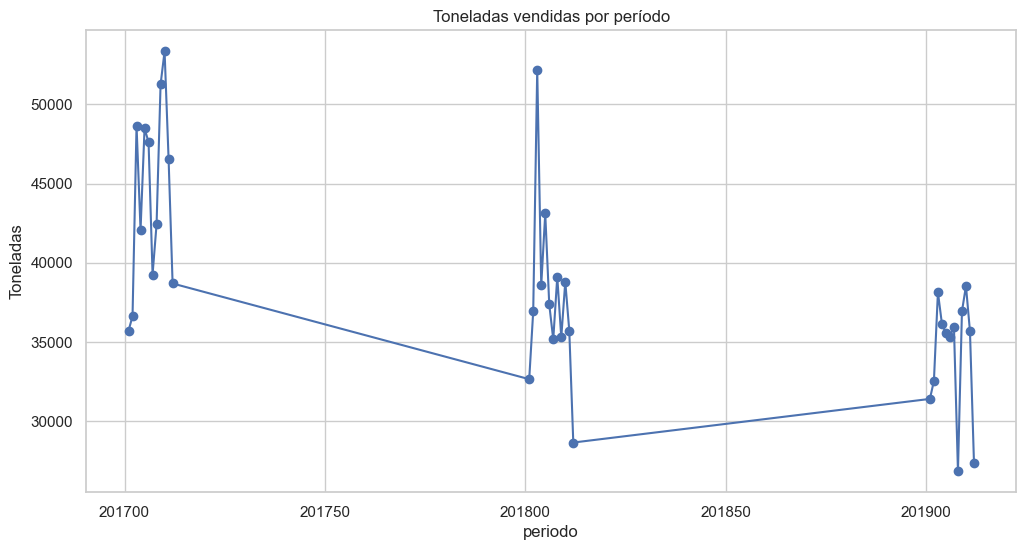

In [9]:
ventas_mes = sellin_full.groupby('periodo')['tn'].sum()
ventas_mes.plot(marker='o', title='Toneladas vendidas por período')
plt.ylabel("Toneladas")
plt.show()


## 🏷️ Ventas totales por marca

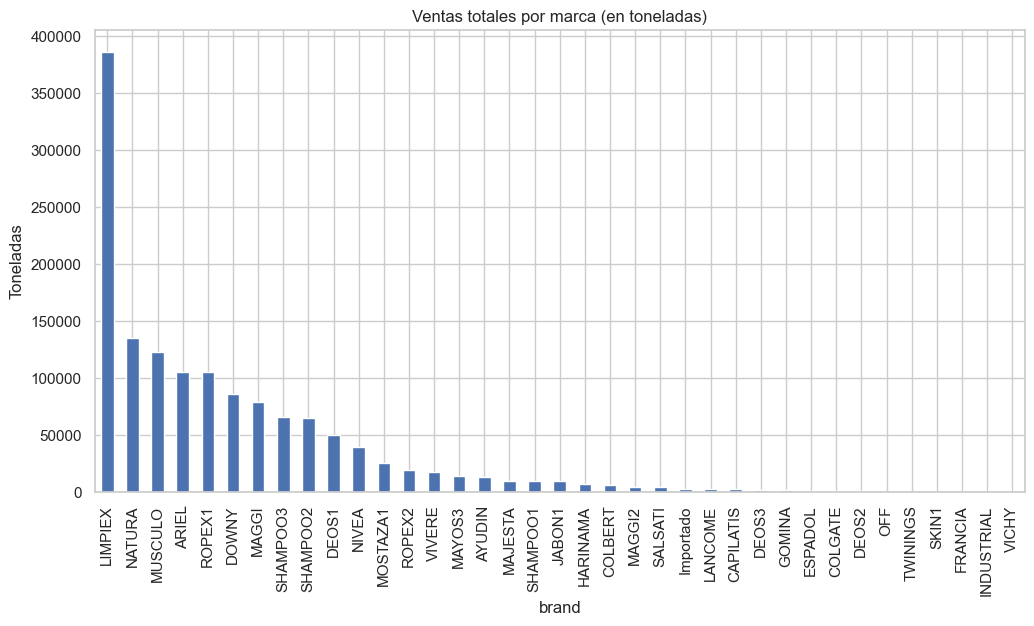

In [10]:
ventas_marca = sellin_full.groupby('brand')['tn'].sum().sort_values(ascending=False)
ventas_marca.plot(kind='bar', title='Ventas totales por marca (en toneladas)')
plt.ylabel("Toneladas")
plt.show()


## ❌ Productos con stock pero sin ventas registradas

In [11]:
ids_stock = stocks['product_id'].unique()
ids_venta = sellin['product_id'].unique()
sin_ventas = set(ids_stock) - set(ids_venta)
productos_sin_ventas = productos[productos['product_id'].isin(sin_ventas)]
print(f"Cantidad de productos con stock pero sin ventas: {len(productos_sin_ventas)}")
productos_sin_ventas


Cantidad de productos con stock pero sin ventas: 0


,cat1,cat2,cat3,brand,sku_size,product_id


## 📏 Relación entre tamaño del SKU y volumen de ventas

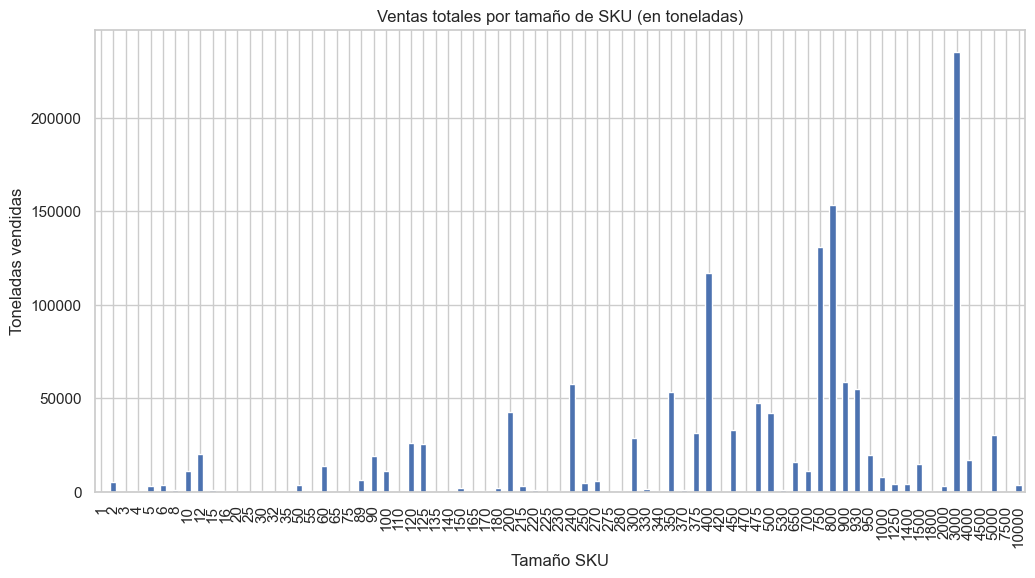

In [12]:
ventas_por_tamano = sellin_full.groupby('sku_size')['tn'].sum().sort_index()
ventas_por_tamano.plot(kind='bar', title='Ventas totales por tamaño de SKU (en toneladas)')
plt.xlabel("Tamaño SKU")
plt.ylabel("Toneladas vendidas")
plt.show()


## 📦 Comparación de ventas por marca y tamaño de SKU

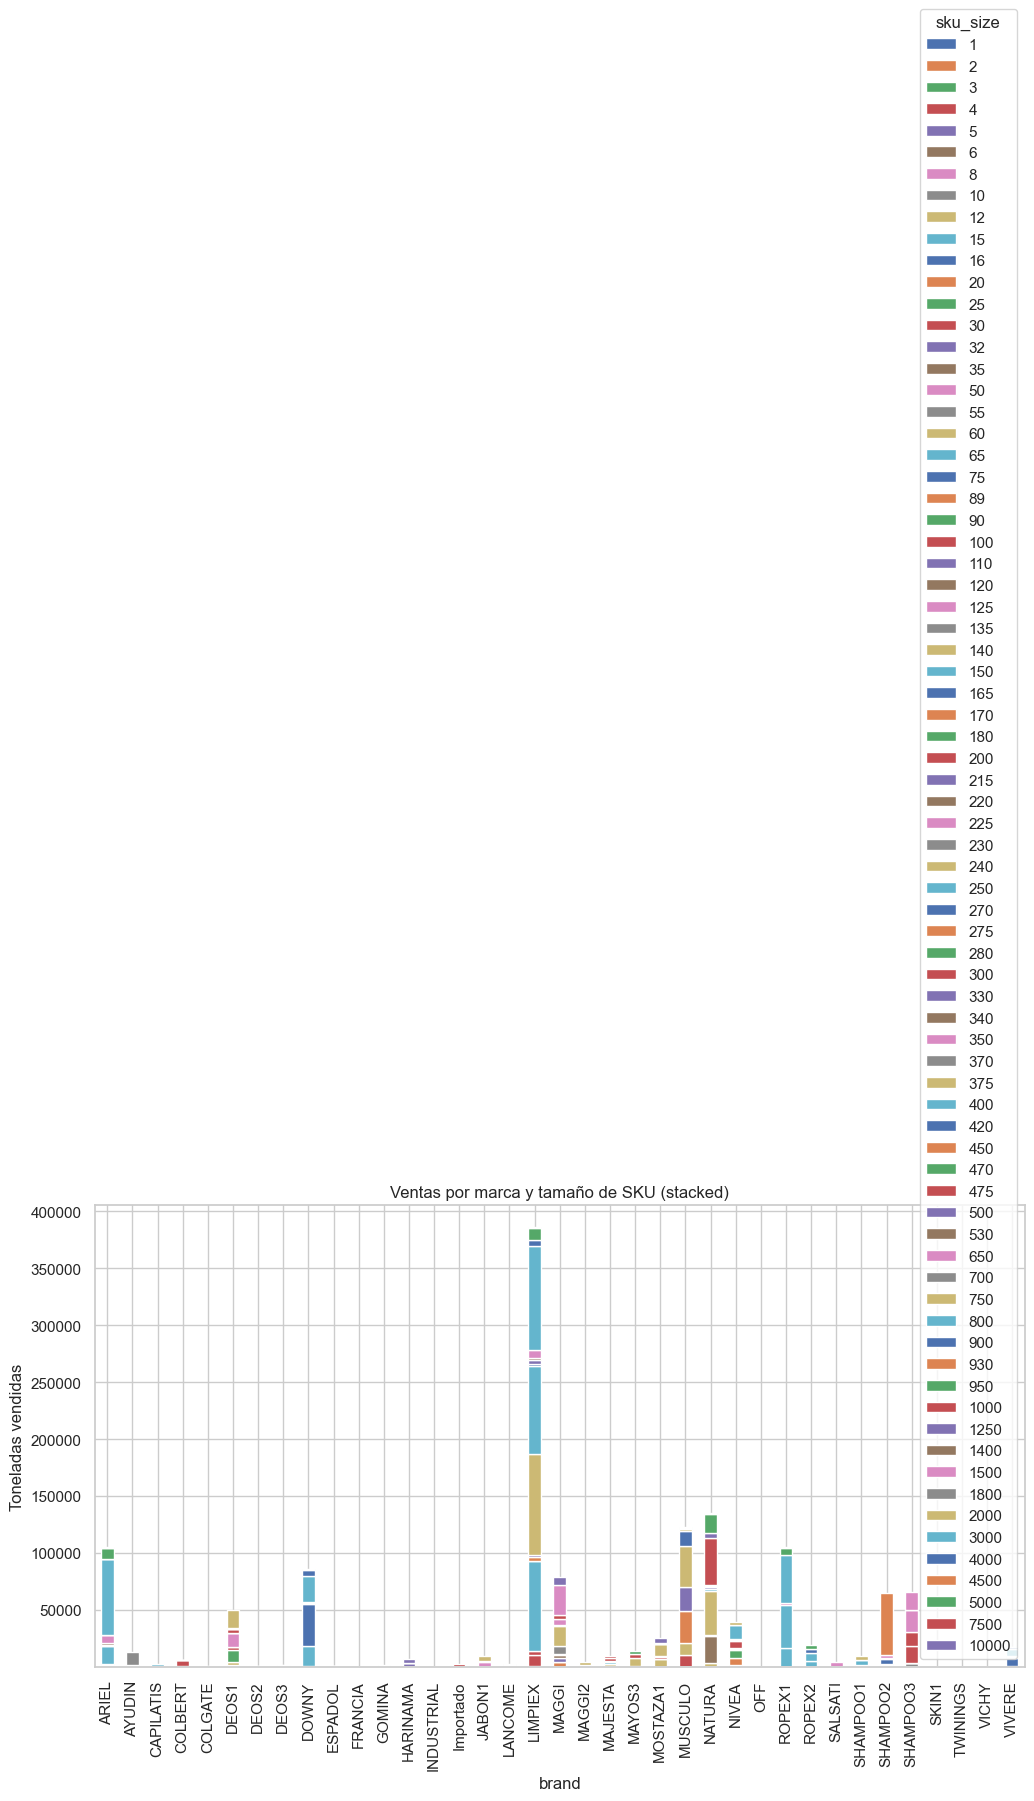

In [13]:
pivot_marca_tamano = sellin_full.groupby(['brand', 'sku_size'])['tn'].sum().unstack().fillna(0)
pivot_marca_tamano.plot(kind='bar', stacked=True, title='Ventas por marca y tamaño de SKU (stacked)')
plt.ylabel("Toneladas vendidas")
plt.show()


## 🔍 Distribución de `cust_request_tn` y `tn`

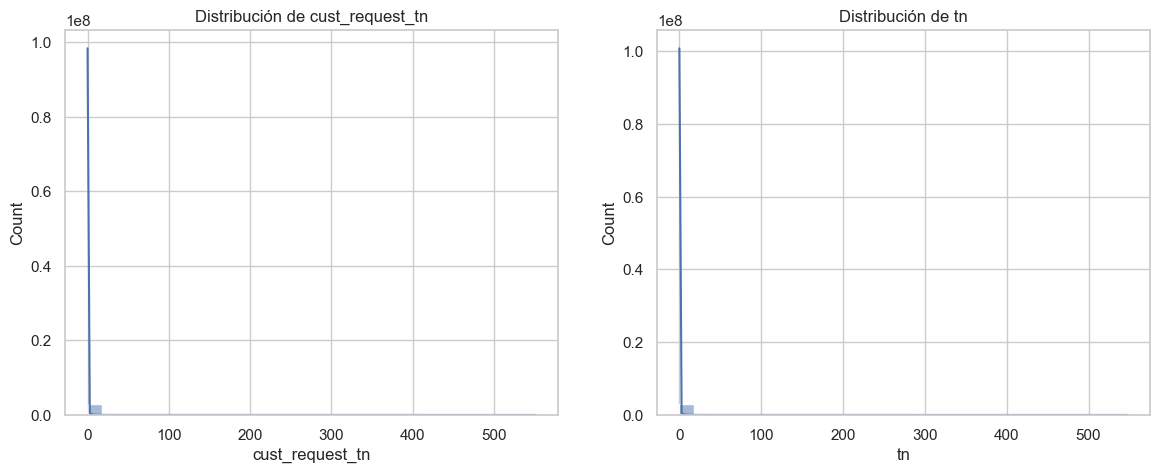

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(sellin_full['cust_request_tn'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribución de cust_request_tn')
sns.histplot(sellin_full['tn'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribución de tn')
plt.show()


## 📈 Matriz de correlación entre variables numéricas

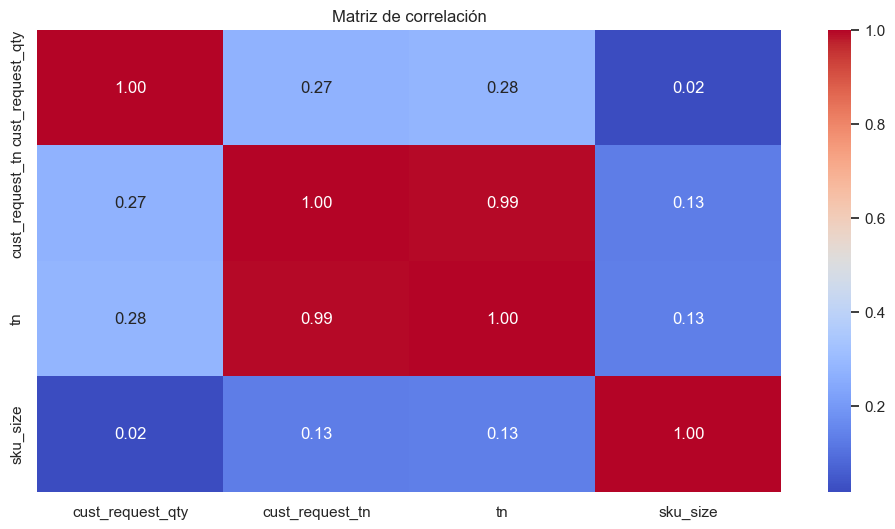

In [15]:
corr_data = sellin_full[['cust_request_qty', 'cust_request_tn', 'tn', 'sku_size']]
corr_matrix = corr_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()


## 🧾 Top 10 clientes por volumen vendido

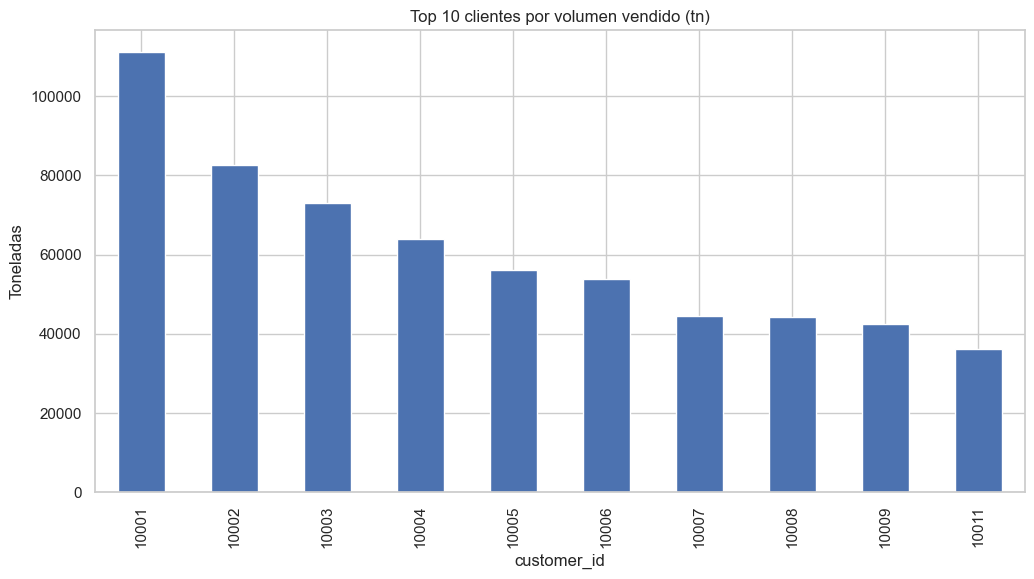

In [16]:
top_clientes = sellin_full.groupby('customer_id')['tn'].sum().sort_values(ascending=False).head(10)
top_clientes.plot(kind='bar', title='Top 10 clientes por volumen vendido (tn)')
plt.ylabel("Toneladas")
plt.show()


## 🔚 Cierre de conexión con la base de datos

In [17]:
conn.close()
